# Keypoint Classification (Single-Hand Model - Improved Training)

In [1]:
import csv
import numpy as np
import tensorflow as tf
import os
import time
import shutil
from sklearn.model_selection import train_test_split
# MODIFIED: Import class_weight
from sklearn.utils import class_weight 

RANDOM_SEED = 42

# Specify each path (Using original single-hand paths)

In [2]:
# Original paths for single-hand model
dataset_path = 'model_asl/keypoint_classifier/keypoint.csv'
label_dataset_path = 'model_asl/keypoint_classifier/keypoint_classifier_label.csv'
model_save_path = 'model_asl/keypoint_classifier/keypoint_classifier.h5'
tflite_save_path = 'model_asl/keypoint_classifier/keypoint_classifier.tflite'
label_save_path = 'model_asl/keypoint_classifier/keypoint_classifier_label_copy.csv' # Save copy here

# Ensure the model directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Set number of classes

In [3]:
# Original 36 classes (A-Z, 0-9)
NUM_CLASSES = 36


# Dataset reading

In [4]:
# Original: Load 42 features (21 landmarks * 2 coords)
NUM_FEATURES = 21 * 2 # 42
X_dataset = np.loadtxt(dataset_path, delimiter=',', dtype='float32', usecols=list(range(1, NUM_FEATURES + 1)))

In [5]:
y_dataset = np.loadtxt(dataset_path, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED, stratify=y_dataset) # Added stratify

# MODIFIED: Calculate Class Weights to handle imbalance

In [7]:
unique_classes = np.unique(y_train)
if len(unique_classes) != NUM_CLASSES:
    print(f"Warning: Found {len(unique_classes)} unique classes in training data, but NUM_CLASSES is set to {NUM_CLASSES}. Adjust NUM_CLASSES if needed.")

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=unique_classes, 
    y=y_train
)

# Keras expects class weights as a dictionary {class_index: weight}
class_weights_dict = dict(zip(unique_classes, class_weights))

print(f"Calculated class weights for {len(class_weights_dict)} classes.")
# print("Class Weights:", class_weights_dict) # Uncomment to see weights

Calculated class weights for 36 classes.


# Model building
# MODIFIED: Increased complexity slightly

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((NUM_FEATURES, )),
    tf.keras.layers.Dropout(0.2),
    # MODIFIED: Increased neurons
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # MODIFIED: Increased neurons
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
# MODIFIED: Model summary reflects new architecture
# Input(42) -> Dropout(0.2) -> Dense(64) -> Dropout(0.4) -> Dense(32) -> Dense(36)
# Dense(64): (42+1)*64 = 2752
# Dense(32): (64+1)*32 = 2080
# Dense(36): (32+1)*36 = 1188
# Total: 2752 + 2080 + 1188 = 6020 params
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 64)                2752      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 36)                1188      
                                                                 
Total params: 6020 (23.52 KB)
Trainable params: 6020 (23.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# Model checkpoint callback - Saves only the best model
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, 
    verbose=1, 
    save_weights_only=False, 
    monitor='val_accuracy', # MODIFIED: Monitor validation accuracy
    mode='max', # MODIFIED: Save model with max validation accuracy
    save_best_only=True)

# Callback for early stopping - Restores best weights
es_callback = tf.keras.callbacks.EarlyStopping(
    patience=30, # MODIFIED: Increased patience slightly
    verbose=1, 
    monitor='val_loss', 
    mode='min', 
    restore_best_weights=True)

# MODIFIED: Add Learning Rate Scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, # Reduce LR by factor of 5 if no improvement
    patience=10, # Wait 10 epochs for improvement
    verbose=1, 
    mode='min',
    min_lr=1e-6 # Minimum learning rate
)

In [11]:
# Model compilation
model.compile(
    optimizer='adam', # Adam is usually a good default
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training
# MODIFIED: Added class_weight and lr_scheduler

In [12]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000, # Early stopping will likely trigger before this
    batch_size=128,
    validation_data=(X_test, y_test),
    # MODIFIED: Pass class weights and LR scheduler
    class_weight=class_weights_dict, 
    callbacks=[cp_callback, es_callback, lr_scheduler]
)

Epoch 1/1000
532/534 [============================>.] - ETA: 0s - loss: 2.6960 - accuracy: 0.2934
Epoch 1: val_accuracy improved from -inf to 0.76980, saving model to model_asl/keypoint_classifier\keypoint_classifier.h5
534/534 [==============================] - 4s 5ms/step - loss: 2.6945 - accuracy: 0.2939 - val_loss: 1.2953 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 2/1000
 28/534 [>.............................] - ETA: 1s - loss: 1.9925 - accuracy: 0.4701

C:\Users\Dan N Mecartin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


522/534 [============================>.] - ETA: 0s - loss: 1.8477 - accuracy: 0.5167
Epoch 2: val_accuracy improved from 0.76980 to 0.80113, saving model to model_asl/keypoint_classifier\keypoint_classifier.h5
534/534 [==============================] - 2s 4ms/step - loss: 1.8500 - accuracy: 0.5171 - val_loss: 0.9596 - val_accuracy: 0.8011 - lr: 0.0010
Epoch 3/1000
531/534 [============================>.] - ETA: 0s - loss: 1.6546 - accuracy: 0.5732
Epoch 3: val_accuracy improved from 0.80113 to 0.83264, saving model to model_asl/keypoint_classifier\keypoint_classifier.h5
534/534 [==============================] - 2s 4ms/step - loss: 1.6522 - accuracy: 0.5734 - val_loss: 0.8129 - val_accuracy: 0.8326 - lr: 0.0010
Epoch 4/1000
523/534 [============================>.] - ETA: 0s - loss: 1.5389 - accuracy: 0.6084
Epoch 4: val_accuracy improved from 0.83264 to 0.87365, saving model to model_asl/keypoint_classifier\keypoint_classifier.h5
534/534 [==============================] - 2s 4ms/step -

# Plot training history

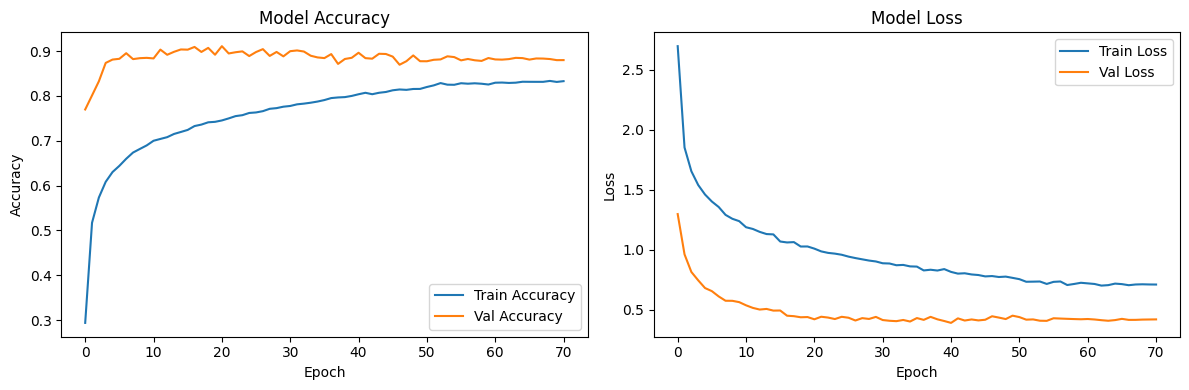

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

In [14]:
# Model evaluation (uses the best weights restored by EarlyStopping)
print("Evaluating model with best weights restored by EarlyStopping:")
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Evaluating model with best weights restored by EarlyStopping:
178/178 [==============================] - 0s 867us/step - loss: 0.3886 - accuracy: 0.8963
Validation Loss: 0.3886
Validation Accuracy: 0.8963


# Loading the best saved model (explicitly, saved by ModelCheckpoint)

In [15]:
# Loading the best model saved by ModelCheckpoint based on val_accuracy
print(f"Loading best model saved at: {model_save_path}")
model = tf.keras.models.load_model(model_save_path)

Loading best model saved at: model_asl/keypoint_classifier/keypoint_classifier.h5


In [16]:
# Re-evaluate with explicitly loaded best model (should be similar to above)
print("\nRe-evaluating explicitly loaded best model:")
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Inference test
test_index = 0
predict_result = model.predict(np.array([X_test[test_index]]))
print("Sample Prediction Probabilities:", np.squeeze(predict_result))
print("Predicted Class Index:", np.argmax(np.squeeze(predict_result)))
print("Actual Class Index:", y_test[test_index])


Re-evaluating explicitly loaded best model:
178/178 [==============================] - 0s 913us/step - loss: 0.4186 - accuracy: 0.9110
Validation Loss: 0.4186
Validation Accuracy: 0.9110
1/1 [==============================] - 0s 63ms/step
Sample Prediction Probabilities: [2.5963243e-03 5.5257878e-03 1.3327039e-05 7.8908191e-04 6.4802036e-02
 5.2240728e-03 2.4190226e-06 1.7005402e-07 8.7055594e-01 3.3477307e-05
 1.4127727e-06 1.8574805e-05 1.0607018e-03 2.5934844e-05 8.0066391e-05
 2.2074268e-07 1.2092178e-06 7.4857717e-06 5.4658083e-03 7.0294895e-04
 5.6927979e-07 4.2820210e-07 1.2212497e-06 1.5928496e-02 3.0920390e-04
 7.4259980e-05 2.5809084e-05 1.6197041e-02 4.6195471e-04 1.2596217e-03
 7.2801480e-04 1.1886622e-04 1.0535957e-04 2.3579774e-03 4.4373460e-03
 1.0870062e-03]
Predicted Class Index: 8
Actual Class Index: 8


# Confusion matrix & Classification Report

712/712 [==============================] - 1s 937us/step


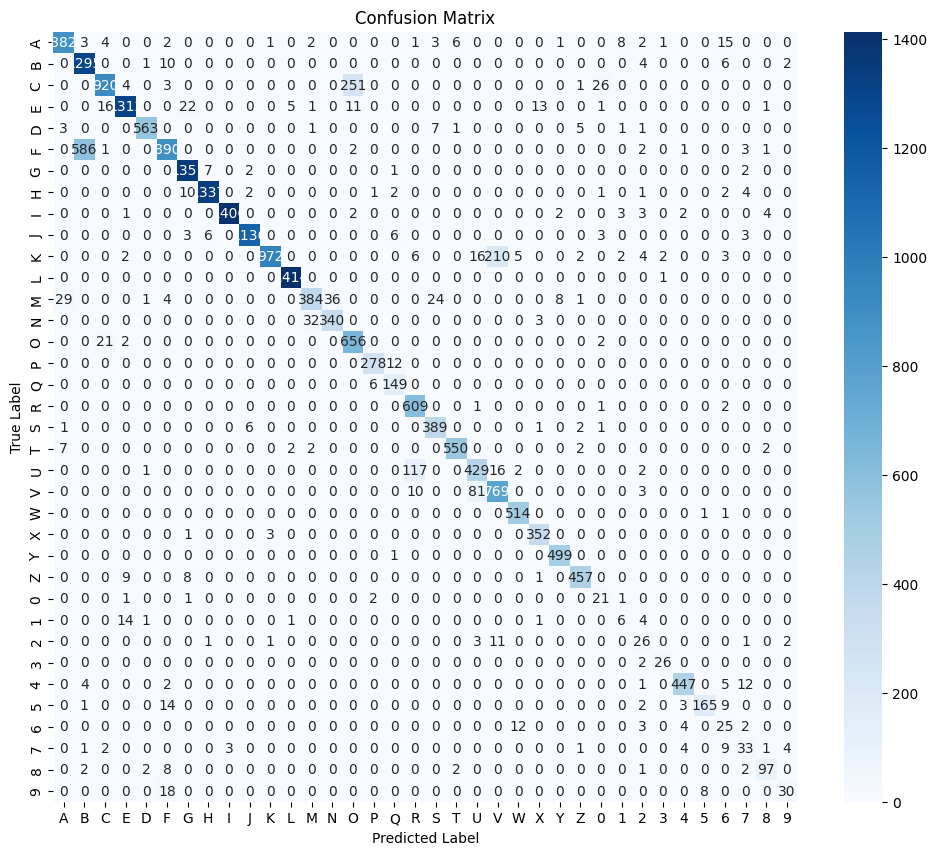


Classification Report
              precision    recall  f1-score   support

           A       0.96      0.95      0.95       931
           B       0.68      0.98      0.81      1318
           C       0.95      0.76      0.85      1205
           E       0.98      0.95      0.96      1382
           D       0.99      0.97      0.98       582
           F       0.94      0.60      0.73      1486
           G       0.97      0.99      0.98      1363
           H       0.99      0.98      0.99      1360
           I       1.00      0.99      0.99      1423
           J       0.99      0.98      0.99      1157
           K       0.99      0.79      0.88      1224
           L       0.99      1.00      1.00      1415
           M       0.91      0.79      0.84       487
           N       0.90      0.91      0.91       375
           O       0.71      0.96      0.82       681
           P       0.97      0.96      0.96       290
           Q       0.87      0.96      0.91       155
    

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, class_labels, report=True):
    # Use labels from 0 to NUM_CLASSES-1 for consistency
    labels_indices = list(range(len(class_labels)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels_indices)
    
    df_cmx = pd.DataFrame(cmx_data, index=class_labels, columns=class_labels)
 
    fig, ax = plt.subplots(figsize=(12, 10)) # Adjusted size for more classes
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False, cmap='Blues') 
    ax.set_ylim(len(class_labels), 0)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    if report:
        print('\nClassification Report')
        # Use zero_division=0 to handle labels with no predictions
        print(classification_report(y_test, y_pred, labels=labels_indices, target_names=class_labels, zero_division=0))

# Load class labels for report
class_labels = []
if os.path.exists(label_dataset_path):
    with open(label_dataset_path, 'r', encoding='utf-8-sig') as f:
        reader = csv.reader(f)
        class_labels = [row[0] for row in reader if row] # Read first column
else:
    print(f"Warning: Label file {label_dataset_path} not found. Using numerical labels.")
    class_labels = [str(i) for i in range(NUM_CLASSES)]

# Ensure class_labels has the correct number of entries
if len(class_labels) != NUM_CLASSES:
     print(f"Warning: Number of labels in {label_dataset_path} ({len(class_labels)}) does not match NUM_CLASSES ({NUM_CLASSES}). Adjust NUM_CLASSES or label file.")
     # Fallback to numerical labels if mismatch
     class_labels = [str(i) for i in range(NUM_CLASSES)]

# Predict all test data
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred, class_labels)

# Convert to model for Tensorflow-Lite

In [18]:
# Load the best model explicitly before conversion
print(f"Loading best model from {model_save_path} for TFLite conversion.")
try:
    converter_model = tf.keras.models.load_model(model_save_path)
except Exception as e:
    print(f"Error loading Keras model: {e}")
    converter_model = None

Loading best model from model_asl/keypoint_classifier/keypoint_classifier.h5 for TFLite conversion.


In [19]:
# Transform model (quantization)
if converter_model:
    print(f"Converting model to TFLite: {tflite_save_path}")
    try:
        converter = tf.lite.TFLiteConverter.from_keras_model(converter_model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_quantized_model = converter.convert()
        
        with open(tflite_save_path, 'wb') as f:
             f.write(tflite_quantized_model)
        print("TFLite model saved successfully.")
    except Exception as e:
        print(f"Error during TFLite conversion: {e}")
else:
    print("Skipping TFLite conversion because Keras model failed to load.")

Converting model to TFLite: model_asl/keypoint_classifier/keypoint_classifier.tflite
INFO:tensorflow:Assets written to: C:\Users\DANNME~1\AppData\Local\Temp\tmp7vi_b2a_\assets


INFO:tensorflow:Assets written to: C:\Users\DANNME~1\AppData\Local\Temp\tmp7vi_b2a_\assets


TFLite model saved successfully.


# Save Label File

In [20]:
# Copy the label file used for training to the model directory
if os.path.exists(label_dataset_path):
    try:
        print(f"Copying label file from {label_dataset_path} to {label_save_path}")
        # Ensure target directory exists
        os.makedirs(os.path.dirname(label_save_path), exist_ok=True)
        shutil.copyfile(label_dataset_path, label_save_path)
        print("Label file saved.")
    except Exception as e:
        print(f"Error copying label file: {e}")
else:
    print(f"Warning: Input label file not found at {label_dataset_path}. Cannot save label file.")

Copying label file from model_asl/keypoint_classifier/keypoint_classifier_label.csv to model_asl/keypoint_classifier/keypoint_classifier_label_copy.csv
Label file saved.


# Inference test with TFLite model

In [21]:
print(f"Loading TFLite model: {tflite_save_path}")
try:
    interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
    interpreter.allocate_tensors()
    print("TFLite model loaded.")
except Exception as e:
    print(f"Error loading TFLite model: {e}")
    interpreter = None

Loading TFLite model: model_asl/keypoint_classifier/keypoint_classifier.tflite
TFLite model loaded.


In [22]:
if interpreter:
    # Get I / O tensor
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    print("TFLite Input Details:", input_details)
    print("TFLite Output Details:", output_details)

TFLite Input Details: [{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 42]), 'shape_signature': array([-1, 42]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
TFLite Output Details: [{'name': 'StatefulPartitionedCall:0', 'index': 10, 'shape': array([ 1, 36]), 'shape_signature': array([-1, 36]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [23]:
if interpreter:
    # Prepare test data (needs to be float32 and correct shape)
    test_index = 0
    if test_index < len(X_test):
        input_data = np.array([X_test[test_index]], dtype=np.float32)
        interpreter.set_tensor(input_details[0]['index'], input_data)
    else:
        print("Test index out of bounds.")

In [24]:
if interpreter and test_index < len(X_test):
    # Inference implementation
    start_time = time.time()
    interpreter.invoke()
    end_time = time.time()
    tflite_results = interpreter.get_tensor(output_details[0]['index'])
    print(f"TFLite Inference Time: {(end_time - start_time)*1000:.2f} ms")

TFLite Inference Time: 1.88 ms


In [25]:
if interpreter and test_index < len(X_test):
    print("TFLite Prediction Probabilities:", np.squeeze(tflite_results))
    predicted_index = np.argmax(np.squeeze(tflite_results))
    print("TFLite Predicted Class Index:", predicted_index)
    print("Actual Class Index:", y_test[test_index])
    
    # Optional: Load labels to show predicted label name
    if os.path.exists(label_save_path):
        with open(label_save_path, 'r', encoding='utf-8-sig') as f:
            labels_list = [line.strip() for line in f.readlines() if line.strip()]
            if 0 <= predicted_index < len(labels_list):
                print("TFLite Predicted Label:", labels_list[predicted_index])
            if 0 <= y_test[test_index] < len(labels_list):
                 print("Actual Label:", labels_list[y_test[test_index]])
    else:
        print(f"Label file not found at {label_save_path}")

TFLite Prediction Probabilities: [2.6738727e-03 5.8704480e-03 1.3748874e-05 8.4627414e-04 6.6766620e-02
 5.5076564e-03 2.4393903e-06 1.8939242e-07 8.6428869e-01 3.3217322e-05
 1.4648984e-06 2.0636437e-05 1.1096988e-03 2.6223866e-05 8.9832109e-05
 2.2953841e-07 1.2824402e-06 6.6694211e-06 5.7421727e-03 7.6194899e-04
 5.6932527e-07 4.3898200e-07 1.2006144e-06 1.7550921e-02 3.0454455e-04
 7.8725905e-05 2.9057526e-05 1.7271413e-02 4.7604396e-04 1.4221098e-03
 7.4598583e-04 1.2954749e-04 1.0605149e-04 2.4008462e-03 4.5800647e-03
 1.1391047e-03]
TFLite Predicted Class Index: 8
Actual Class Index: 8
TFLite Predicted Label: I
Actual Label: I
